### This is the notebook for using different time sequence to evaluate the performance of CNN and CNN_LSTM

## data preparation and preprocess

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape,LSTM,MaxPooling1D,Conv1D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle
np.random.seed(12345)



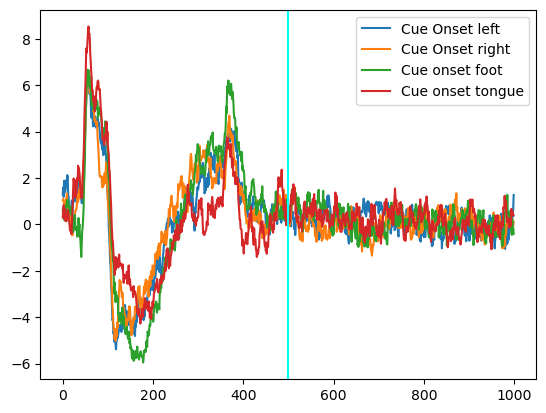

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("/kaggle/input/eeg-247-project/X_test.npy")
y_test = np.load("/kaggle/input/eeg-247-project/y_test.npy")
person_train_valid = np.load("/kaggle/input/eeg-247-project/person_train_valid.npy")
X_train_valid = np.load("/kaggle/input/eeg-247-project/X_train_valid.npy")
y_train_valid = np.load("/kaggle/input/eeg-247-project/y_train_valid.npy")
person_test = np.load("/kaggle/input/eeg-247-project/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

y_test_original=y_test#store original test label

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])





In [3]:
def data_prep(X,y,sub_sample,average,noise,trim_time=500):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:trim_time]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [4]:
#data processing for segmenting sequence
#trim_time can be adjusted to acquire different time length
#250 500 750 1000

def process_data(X_train_valid,y_train_valid,trim_time=500):   
    x_train_valid_p, y_train_valid_p = data_prep(X_train_valid, y_train_valid, 2, 2, True,trim_time)
    y_train_valid_p = to_categorical(y_train_valid_p, 4)
    x_train_valid_p = x_train_valid_p.reshape(x_train_valid_p.shape[0], x_train_valid_p.shape[1], x_train_valid_p.shape[2], 1)
    x_train_valid_p = np.swapaxes(x_train_valid_p, 1,3)
    x_train_valid_p = np.swapaxes(x_train_valid_p, 1,2)
    return x_train_valid_p,y_train_valid_p 



## define basic CNN model and CNN-LSTM model

In [5]:
# Building the CNN model using sequential class
def Basic_CNN(trim_time=500):
  basic_cnn_model = Sequential()

# Conv block 1 conv+maxpooling+batchnorm 
  basic_cnn_model.add(Conv2D(filters=10, kernel_size=(10,1), padding='same', activation='elu', input_shape=(int(trim_time/2),1,22)))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

# Conv block 2
  basic_cnn_model.add(Conv2D(filters=25, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))


# Conv Block 3
  basic_cnn_model.add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

# Conv Block 4
  basic_cnn_model.add(Conv2D(filters=100, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))

 # Conv Block 5
  basic_cnn_model.add(Conv2D(filters=200, kernel_size=(10,1), padding='same', activation='elu'))
  basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  basic_cnn_model.add(BatchNormalization())
  basic_cnn_model.add(Dropout(0.5))




# FC layer + Softmax activation
  basic_cnn_model.add(Flatten()) # Flattens the input
  basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
  basic_cnn_model.summary()
  return basic_cnn_model

#basic_cnn_model.summary()

In [6]:
def CNN_LSTM(dropout=0.5, units=150, add_layer = False,trim_time=500):
  # Building the CNN model using sequential class
  hybrid_cnn_lstm_model = Sequential()

  # Conv. block 1
  hybrid_cnn_lstm_model.add(Conv1D(filters=25, kernel_size=10, padding='same', activation='elu', input_shape=(int(trim_time/2),22)))
  hybrid_cnn_lstm_model.add(MaxPooling1D(pool_size=3, padding='same')) # Read the keras documentation
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 2
  hybrid_cnn_lstm_model.add(Conv1D(filters=50, kernel_size=10, padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling1D(pool_size=3, padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 3
  hybrid_cnn_lstm_model.add(Conv1D(filters=100, kernel_size=10, padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling1D(pool_size=3, padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # Conv. block 4
  hybrid_cnn_lstm_model.add(Conv1D(filters=200, kernel_size=10, padding='same', activation='elu'))
  hybrid_cnn_lstm_model.add(MaxPooling1D(pool_size=3, padding='same'))
  hybrid_cnn_lstm_model.add(BatchNormalization())
  hybrid_cnn_lstm_model.add(Dropout(0.5))

  # LSTM layer 1
  hybrid_cnn_lstm_model.add(LSTM(units, dropout=dropout, recurrent_dropout=0, return_sequences=True))
  if add_layer == True:
    hybrid_cnn_lstm_model.add(LSTM(units, dropout=dropout, recurrent_dropout=0, return_sequences=True))
  #LSTM layer 2
  hybrid_cnn_lstm_model.add(LSTM(10, dropout=dropout, recurrent_dropout=0, return_sequences=False))
  #FC layer
  hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation
  return hybrid_cnn_lstm_model

## （1）Basic CNN model

In [17]:
time_sequence=[250,500,750,1000] #use 250 500 750 1000 time bins respectively
CNN_time_accuracy=[]
for trim_time in time_sequence:
    X_train_sequence,y_train_sequence=process_data(X_train_valid,y_train_valid,trim_time=trim_time)
    X_test_sequence,y_test_sequence=process_data(X_test,y_test_original,trim_time=trim_time)
    print('shape of train sequence',np.shape(X_train_sequence))
    print('shape of train sequence label',np.shape(y_train_sequence))
    print('shape of test sequence',np.shape(X_test_sequence))
    print('shape of test sequence label',np.shape(y_test_sequence))
    learning_rate = 1e-3
    epochs=100
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    basic_cnn_model=Basic_CNN(trim_time=trim_time)
    basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
    cnn_model_results = basic_cnn_model.fit(X_train_sequence,y_train_sequence,
             batch_size=64,
             epochs=epochs,verbose=True)
    cnn_score= basic_cnn_model.evaluate(X_test_sequence,y_test_sequence,verbose=0)
    CNN_time_accuracy.append(cnn_score[1])

    print('Test accuracy of the basic CNN model:',cnn_score[1])

Shape of X after trimming: (2115, 22, 250)
Shape of X after maxpooling: (2115, 22, 125)
Shape of X after averaging+noise and concatenating: (4230, 22, 125)
Shape of X after subsampling and concatenating: (8460, 22, 125)
Shape of X after trimming: (443, 22, 250)
Shape of X after maxpooling: (443, 22, 125)
Shape of X after averaging+noise and concatenating: (886, 22, 125)
Shape of X after subsampling and concatenating: (1772, 22, 125)
shape of train sequence (8460, 125, 1, 22)
shape of train sequence label (8460, 4)
shape of test sequence (1772, 125, 1, 22)
shape of test sequence label (1772, 4)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 125, 1, 10)        2210      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 42, 1, 10)        0         
 g2D)                                          

2023-03-17 09:00:28.576988: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 2s 6ms/step - loss: 2.0047 - accuracy: 0.2618
Epoch 2/100
133/133 [==============================] - 1s 6ms/step - loss: 1.6284 - accuracy: 0.2728
Epoch 3/100
133/133 [==============================] - 1s 6ms/step - loss: 1.4889 - accuracy: 0.2883
Epoch 4/100
133/133 [==============================] - 1s 6ms/step - loss: 1.4306 - accuracy: 0.2998
Epoch 5/100
133/133 [==============================] - 1s 6ms/step - loss: 1.3703 - accuracy: 0.3317
Epoch 6/100
133/133 [==============================] - 1s 8ms/step - loss: 1.3350 - accuracy: 0.3606
Epoch 7/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2991 - accuracy: 0.3882
Epoch 8/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2705 - accuracy: 0.4061
Epoch 9/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2545 - accuracy: 0.4144
Epoch 10/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2390 - accuracy: 0.4310
E

2023-03-17 09:02:55.229083: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 2s 7ms/step - loss: 2.0269 - accuracy: 0.2762
Epoch 2/100
133/133 [==============================] - 1s 8ms/step - loss: 1.5645 - accuracy: 0.3164
Epoch 3/100
133/133 [==============================] - 1s 6ms/step - loss: 1.4178 - accuracy: 0.3526
Epoch 4/100
133/133 [==============================] - 1s 6ms/step - loss: 1.3069 - accuracy: 0.4054
Epoch 5/100
133/133 [==============================] - 1s 7ms/step - loss: 1.2445 - accuracy: 0.4345
Epoch 6/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2181 - accuracy: 0.4495
Epoch 7/100
133/133 [==============================] - 1s 6ms/step - loss: 1.1755 - accuracy: 0.4839
Epoch 8/100
133/133 [==============================] - 1s 7ms/step - loss: 1.1483 - accuracy: 0.4991
Epoch 9/100
133/133 [==============================] - 1s 7ms/step - loss: 1.1336 - accuracy: 0.5115
Epoch 10/100
133/133 [==============================] - 1s 7ms/step - loss: 1.1139 - accuracy: 0.5241
E

2023-03-17 09:04:32.087018: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/dropout_20/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 2s 8ms/step - loss: 2.0095 - accuracy: 0.2631
Epoch 2/100
133/133 [==============================] - 1s 7ms/step - loss: 1.5723 - accuracy: 0.3022
Epoch 3/100
133/133 [==============================] - 1s 8ms/step - loss: 1.4482 - accuracy: 0.3214
Epoch 4/100
133/133 [==============================] - 1s 7ms/step - loss: 1.3689 - accuracy: 0.3564
Epoch 5/100
133/133 [==============================] - 1s 7ms/step - loss: 1.3057 - accuracy: 0.3949
Epoch 6/100
133/133 [==============================] - 1s 7ms/step - loss: 1.2696 - accuracy: 0.4137
Epoch 7/100
133/133 [==============================] - 1s 7ms/step - loss: 1.2307 - accuracy: 0.4339
Epoch 8/100
133/133 [==============================] - 1s 7ms/step - loss: 1.2126 - accuracy: 0.4449
Epoch 9/100
133/133 [==============================] - 1s 7ms/step - loss: 1.1892 - accuracy: 0.4671
Epoch 10/100
133/133 [==============================] - 1s 7ms/step - loss: 1.1678 - accuracy: 0.4843
E

2023-03-17 09:07:03.643182: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/dropout_25/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 3s 10ms/step - loss: 2.0402 - accuracy: 0.2738
Epoch 2/100
133/133 [==============================] - 1s 7ms/step - loss: 1.6129 - accuracy: 0.2941
Epoch 3/100
133/133 [==============================] - 1s 7ms/step - loss: 1.4698 - accuracy: 0.3271
Epoch 4/100
133/133 [==============================] - 1s 7ms/step - loss: 1.3824 - accuracy: 0.3550
Epoch 5/100
133/133 [==============================] - 1s 8ms/step - loss: 1.3184 - accuracy: 0.3849
Epoch 6/100
133/133 [==============================] - 1s 8ms/step - loss: 1.2622 - accuracy: 0.4203
Epoch 7/100
133/133 [==============================] - 1s 7ms/step - loss: 1.2252 - accuracy: 0.4492
Epoch 8/100
133/133 [==============================] - 1s 7ms/step - loss: 1.2098 - accuracy: 0.4508
Epoch 9/100
133/133 [==============================] - 1s 7ms/step - loss: 1.1749 - accuracy: 0.4755
Epoch 10/100
133/133 [==============================] - 1s 7ms/step - loss: 1.1598 - accuracy: 0.4819


## (2) CNN_LSTM

In [13]:
#CNN_LSTM
time_sequence=[250,500,750,1000]
CNN_LSTM_time_accuracy1=[]
for trim_time in time_sequence:
    X_train_sequence,y_train_sequence=process_data(X_train_valid,y_train_valid,trim_time=trim_time)
    X_test_sequence,y_test_sequence=process_data(X_test,y_test_original,trim_time=trim_time)
    X_train_sequence = X_train_sequence.reshape((X_train_sequence.shape[0], X_train_sequence.shape[1], X_train_sequence.shape[3]))
    X_test_sequence = X_test_sequence.reshape((X_test_sequence.shape[0], X_test_sequence.shape[1], X_test_sequence.shape[3]))
    print('shape of train sequence',np.shape(X_train_sequence))
    print('shape of train sequence label',np.shape(y_train_sequence))
    print('shape of test sequence',np.shape(X_test_sequence))
    print('shape of test sequence label',np.shape(y_test_sequence))
    learning_rate = 1e-3
    epochs=100
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    hybrid_CNN_LSTM_model=CNN_LSTM(trim_time=trim_time)
    hybrid_CNN_LSTM_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
    hybrid_CNN_LSTM_results =  hybrid_CNN_LSTM_model.fit(X_train_sequence,y_train_sequence,
             batch_size=64,
             epochs=epochs,verbose=True)
    cnn_lstm_score= hybrid_CNN_LSTM_model.evaluate(X_test_sequence,y_test_sequence,verbose=0)
    CNN_LSTM_time_accuracy1.append(cnn_lstm_score[1])
    print('Test accuracy of the CNN_LSTM model:',cnn_lstm_score[1])

Shape of X after trimming: (2115, 22, 250)
Shape of X after maxpooling: (2115, 22, 125)
Shape of X after averaging+noise and concatenating: (4230, 22, 125)
Shape of X after subsampling and concatenating: (8460, 22, 125)
Shape of X after trimming: (443, 22, 250)
Shape of X after maxpooling: (443, 22, 125)
Shape of X after averaging+noise and concatenating: (886, 22, 125)
Shape of X after subsampling and concatenating: (1772, 22, 125)
shape of train sequence (8460, 125, 22)
shape of train sequence label (8460, 4)
shape of test sequence (1772, 125, 22)
shape of test sequence label (1772, 4)
Epoch 1/100
133/133 [==============================] - 6s 12ms/step - loss: 1.3751 - accuracy: 0.2935
Epoch 2/100
133/133 [==============================] - 1s 11ms/step - loss: 1.3239 - accuracy: 0.3630
Epoch 3/100
133/133 [==============================] - 1s 11ms/step - loss: 1.2628 - accuracy: 0.4169
Epoch 4/100
133/133 [==============================] - 2s 11ms/step - loss: 1.2268 - accuracy: 0.45

## Investigate time points between 250 and 500

## (1) CNN

In [7]:
time_sequence1=[300,350,400,450]
new_CNN_time_sequence=[]
for trim_time in time_sequence1:
    X_train_sequence,y_train_sequence=process_data(X_train_valid,y_train_valid,trim_time=trim_time)
    X_test_sequence,y_test_sequence=process_data(X_test,y_test_original,trim_time=trim_time)
    print('shape of train sequence',np.shape(X_train_sequence))
    print('shape of train sequence label',np.shape(y_train_sequence))
    print('shape of test sequence',np.shape(X_test_sequence))
    print('shape of test sequence label',np.shape(y_test_sequence))
    learning_rate = 1e-3
    epochs=100
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    basic_cnn_model=Basic_CNN(trim_time=trim_time)
    basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
    cnn_model_results = basic_cnn_model.fit(X_train_sequence,y_train_sequence,
             batch_size=64,
             epochs=epochs,verbose=True)
    cnn_score= basic_cnn_model.evaluate(X_test_sequence,y_test_sequence,verbose=0)
    new_CNN_time_sequence.append(cnn_score[1])

    print('Test accuracy of the basic CNN model:',cnn_score[1])

Shape of X after trimming: (2115, 22, 300)
Shape of X after maxpooling: (2115, 22, 150)
Shape of X after averaging+noise and concatenating: (4230, 22, 150)
Shape of X after subsampling and concatenating: (8460, 22, 150)
Shape of X after trimming: (443, 22, 300)
Shape of X after maxpooling: (443, 22, 150)
Shape of X after averaging+noise and concatenating: (886, 22, 150)
Shape of X after subsampling and concatenating: (1772, 22, 150)
shape of train sequence (8460, 150, 1, 22)
shape of train sequence label (8460, 4)
shape of test sequence (1772, 150, 1, 22)
shape of test sequence label (1772, 4)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 1, 10)        2210      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 1, 10)        0         
 )                                               

2023-03-17 19:06:49.096106: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 14s 7ms/step - loss: 2.0226 - accuracy: 0.2739
Epoch 2/100
133/133 [==============================] - 1s 6ms/step - loss: 1.6445 - accuracy: 0.2810
Epoch 3/100
133/133 [==============================] - 1s 6ms/step - loss: 1.4992 - accuracy: 0.3004
Epoch 4/100
133/133 [==============================] - 1s 8ms/step - loss: 1.4292 - accuracy: 0.3038
Epoch 5/100
133/133 [==============================] - 1s 6ms/step - loss: 1.3844 - accuracy: 0.3294
Epoch 6/100
133/133 [==============================] - 1s 6ms/step - loss: 1.3371 - accuracy: 0.3558
Epoch 7/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2958 - accuracy: 0.3891
Epoch 8/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2710 - accuracy: 0.4157
Epoch 9/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2477 - accuracy: 0.4267
Epoch 10/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2264 - accuracy: 0.4488


2023-03-17 19:09:14.943520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 2s 8ms/step - loss: 2.0117 - accuracy: 0.2726
Epoch 2/100
133/133 [==============================] - 1s 6ms/step - loss: 1.6042 - accuracy: 0.2978
Epoch 3/100
133/133 [==============================] - 1s 6ms/step - loss: 1.4748 - accuracy: 0.3209
Epoch 4/100
133/133 [==============================] - 1s 6ms/step - loss: 1.3778 - accuracy: 0.3574
Epoch 5/100
133/133 [==============================] - 1s 6ms/step - loss: 1.3124 - accuracy: 0.3837
Epoch 6/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2802 - accuracy: 0.4000
Epoch 7/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2522 - accuracy: 0.4215
Epoch 8/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2331 - accuracy: 0.4362
Epoch 9/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2175 - accuracy: 0.4424
Epoch 10/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2070 - accuracy: 0.4423
E

2023-03-17 19:11:41.733644: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 2s 7ms/step - loss: 1.9799 - accuracy: 0.2801
Epoch 2/100
133/133 [==============================] - 1s 6ms/step - loss: 1.6321 - accuracy: 0.2820
Epoch 3/100
133/133 [==============================] - 1s 6ms/step - loss: 1.4637 - accuracy: 0.3119
Epoch 4/100
133/133 [==============================] - 1s 6ms/step - loss: 1.3971 - accuracy: 0.3375
Epoch 5/100
133/133 [==============================] - 1s 6ms/step - loss: 1.3500 - accuracy: 0.3539
Epoch 6/100
133/133 [==============================] - 1s 6ms/step - loss: 1.3010 - accuracy: 0.3856
Epoch 7/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2613 - accuracy: 0.4082
Epoch 8/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2353 - accuracy: 0.4288
Epoch 9/100
133/133 [==============================] - 1s 7ms/step - loss: 1.2186 - accuracy: 0.4374
Epoch 10/100
133/133 [==============================] - 1s 6ms/step - loss: 1.1947 - accuracy: 0.4563
E

2023-03-17 19:14:08.131337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_15/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


133/133 [==============================] - 2s 7ms/step - loss: 2.0314 - accuracy: 0.2668
Epoch 2/100
133/133 [==============================] - 1s 6ms/step - loss: 1.6232 - accuracy: 0.2907
Epoch 3/100
133/133 [==============================] - 1s 6ms/step - loss: 1.4671 - accuracy: 0.3167
Epoch 4/100
133/133 [==============================] - 1s 6ms/step - loss: 1.4010 - accuracy: 0.3304
Epoch 5/100
133/133 [==============================] - 1s 8ms/step - loss: 1.3416 - accuracy: 0.3574
Epoch 6/100
133/133 [==============================] - 1s 8ms/step - loss: 1.2871 - accuracy: 0.3926
Epoch 7/100
133/133 [==============================] - 1s 7ms/step - loss: 1.2494 - accuracy: 0.4196
Epoch 8/100
133/133 [==============================] - 1s 6ms/step - loss: 1.2167 - accuracy: 0.4382
Epoch 9/100
133/133 [==============================] - 1s 6ms/step - loss: 1.1947 - accuracy: 0.4535
Epoch 10/100
133/133 [==============================] - 1s 6ms/step - loss: 1.1808 - accuracy: 0.4645
E

In [9]:
new_CNN_time_sequence

[0.6997742652893066,
 0.7054176330566406,
 0.6839728951454163,
 0.7093679308891296]

## (2) CNN_LSTM

In [10]:
#try new time sequence on CNN_LSTM
time_sequence1=[300,350,400,450]# between 250-500
CNN_LSTM_new_sequence=[]
for trim_time in time_sequence1:
    X_train_sequence,y_train_sequence=process_data(X_train_valid,y_train_valid,trim_time=trim_time)
    X_test_sequence,y_test_sequence=process_data(X_test,y_test_original,trim_time=trim_time)
    X_train_sequence = X_train_sequence.reshape((X_train_sequence.shape[0], X_train_sequence.shape[1], X_train_sequence.shape[3]))
    X_test_sequence = X_test_sequence.reshape((X_test_sequence.shape[0], X_test_sequence.shape[1], X_test_sequence.shape[3]))
    print('shape of train sequence',np.shape(X_train_sequence))
    print('shape of train sequence label',np.shape(y_train_sequence))
    print('shape of test sequence',np.shape(X_test_sequence))
    print('shape of test sequence label',np.shape(y_test_sequence))
    learning_rate = 1e-3
    epochs=100
    cnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    hybrid_CNN_LSTM_model=CNN_LSTM(trim_time=trim_time)
    hybrid_CNN_LSTM_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])
    hybrid_CNN_LSTM_results =  hybrid_CNN_LSTM_model.fit(X_train_sequence,y_train_sequence,
             batch_size=64,
             epochs=epochs,verbose=True)
    cnn_lstm_score= hybrid_CNN_LSTM_model.evaluate(X_test_sequence,y_test_sequence,verbose=0)
    CNN_LSTM_new_sequence.append(cnn_lstm_score[1])
    print('Test accuracy of the CNN_LSTM model:',cnn_lstm_score[1])

Shape of X after trimming: (2115, 22, 300)
Shape of X after maxpooling: (2115, 22, 150)
Shape of X after averaging+noise and concatenating: (4230, 22, 150)
Shape of X after subsampling and concatenating: (8460, 22, 150)
Shape of X after trimming: (443, 22, 300)
Shape of X after maxpooling: (443, 22, 150)
Shape of X after averaging+noise and concatenating: (886, 22, 150)
Shape of X after subsampling and concatenating: (1772, 22, 150)
shape of train sequence (8460, 150, 22)
shape of train sequence label (8460, 4)
shape of test sequence (1772, 150, 22)
shape of test sequence label (1772, 4)
Epoch 1/100
133/133 [==============================] - 8s 13ms/step - loss: 1.3790 - accuracy: 0.2876
Epoch 2/100
133/133 [==============================] - 2s 12ms/step - loss: 1.3395 - accuracy: 0.3500
Epoch 3/100
133/133 [==============================] - 2s 12ms/step - loss: 1.2750 - accuracy: 0.4057
Epoch 4/100
133/133 [==============================] - 2s 11ms/step - loss: 1.2282 - accuracy: 0.43